# Setup

In [1]:
import joblib
from collections import defaultdict
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors

In [3]:
DATA_DIR = "/Anime-Recommendation-main/data"

In [4]:
df = pd.read_csv('animelist.csv')

In [5]:
df.head()

,user_id,anime_id,rating,watching_status,watched_episodes
0,0,67,9,1,1
1,0,6702,7,1,4
2,0,242,10,1,4
3,0,4898,0,1,1
4,0,21,10,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109224747 entries, 0 to 109224746
Data columns (total 5 columns):
 #   Column            Dtype
---  ------            -----
 0   user_id           int64
 1   anime_id          int64
 2   rating            int64
 3   watching_status   int64
 4   watched_episodes  int64
dtypes: int64(5)
memory usage: 4.1 GB


In [7]:
f'{len(df):,}'

'109,224,747'

In [8]:
df.nunique()

user_id             325770
anime_id             17562
rating                  11
watching_status          9
watched_episodes      1464
dtype: int64

# Remove 18+ contents

In [9]:
anime_df = pd.read_csv('anime.csv')
anime_df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26.0,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1.0,"Sep 1, 2001",NaN,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26.0,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26.0,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [10]:
import pandas as pd

hentai_rating_count = len(anime_df[anime_df['Rating'].str.contains('Hentai', na=False)])
hentai_genres_count = len(anime_df[anime_df['Genres'].str.contains('Hentai', na=False)])

print("Count of 'Hentai' in Rating:", hentai_rating_count)
print("Count of 'Hentai' in Genres:", hentai_genres_count)


Count of 'Hentai' in Rating: 1345
Count of 'Hentai' in Genres: 1348


In [11]:
import pandas as pd


filtered_anime_df = anime_df.dropna(subset=['Genres']) 

adult_ids = filtered_anime_df.loc[filtered_anime_df['Genres'].str.contains('Hentai'), 'MAL_ID']


In [12]:
df = df[~df.anime_id.isin(adult_ids)]

In [13]:
f'{len(df):,}'

'107,289,602'

# Check watching status and ratings

In [14]:
print(sorted(df.rating.unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [15]:
df.watched_episodes.unique()

array([   1,    4,    0, ..., 1266, 1039, 6688])

In [16]:
df.watching_status.unique()

array([ 1,  2,  3,  4,  6,  0,  5, 33, 55])

In [17]:
watching_status_df = pd.read_csv('watching_status.csv')
watching_status_df

,status,description
0,1,Currently Watching
1,2,Completed
2,3,On Hold
3,4,Dropped
4,6,Plan to Watch


In [18]:
df.watching_status.value_counts()

watching_status
2     66855106
6     27495987
1      5121943
4      4198605
3      3617482
0          470
5            6
33           2
55           1
Name: count, dtype: int64

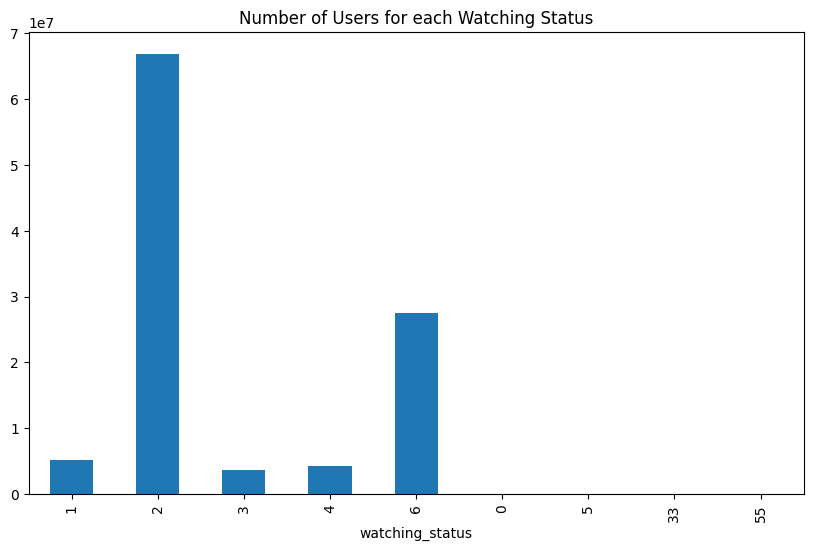

In [19]:
df.watching_status.value_counts(sort=False).plot(kind='bar', figsize=(10, 6))
plt.title("Number of Users for each Watching Status");

In [20]:
print("Total number of records with unknown watching statuses:")
print(df[df.watching_status.isin((0, 5, 33, 55))].anime_id.nunique())
print("Unique ratings for unknown watching statuses:")
print(df[df.watching_status.isin((0, 5, 33, 55))].rating.unique())

Total number of records with unknown watching statuses:
466
Unique ratings for unknown watching statuses:
[ 0  7 10  6  8  9  1  4  5]


These should be users that HAVE NOT ADDED the animes into their lists, or not rated yet? But MyAnimeList website automatically assigns "Watching" status (coded as 1 here) by default when you rated an anime, which does not make sense considering the ratings here do not only consist of 0 (which I assumed to be including '**Unknown**' ratings)

This is a concern as I'm afraid it might affect the recommendation system due to the inaccurate ratings, especially because of the **huge number of 0 ratings** as shown in the figure below.

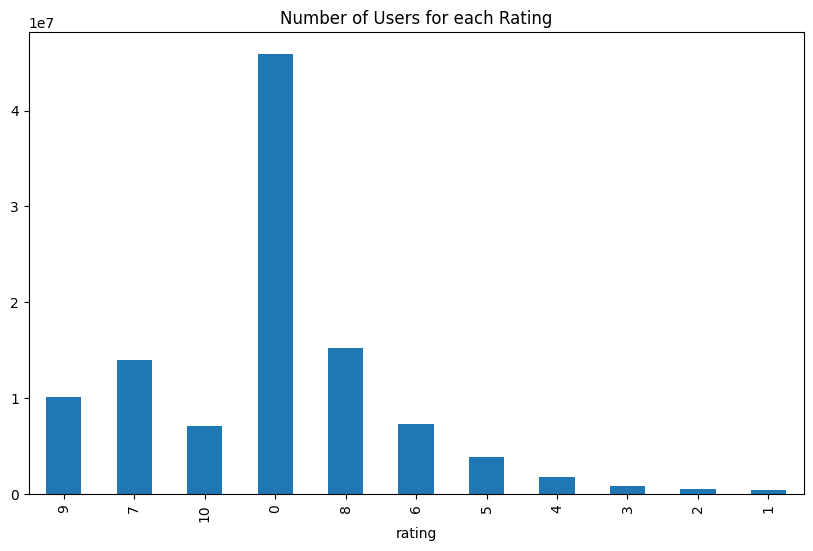

In [21]:
df.rating.value_counts(sort=False).plot(kind='bar', figsize=(10,6))
plt.title('Number of Users for each Rating');

In [22]:
df.user_id.nunique()

325177

In [23]:
# num_ratings_per_user = df.groupby('user_id')['rating'].count()
num_ratings_per_user = df['user_id'].value_counts().sort_index()
num_ratings_per_user

user_id
0          74
1         139
2         235
3         358
4         156
         ... 
353400    110
353401     73
353402     44
353403    214
353404     32
Name: count, Length: 325177, dtype: int64

In [24]:
min_anime_rated = 200
len(num_ratings_per_user[num_ratings_per_user > min_anime_rated])

174721

In [25]:
user_ids = num_ratings_per_user[num_ratings_per_user > min_anime_rated].index
user_ids

Index([     2,      3,      6,     11,     12,     16,     17,     19,     21,
           25,
       ...
       353385, 353386, 353387, 353389, 353390, 353391, 353392, 353395, 353398,
       353403],
      dtype='int64', name='user_id', length=174721)

In [26]:
num_users_per_anime = df.groupby('anime_id')['user_id'].count()

In [27]:
num_users_per_anime

anime_id
1        145973
5         48231
6         88007
7         25688
8          3611
          ...  
48481         4
48483       111
48488       214
48491        50
48492         7
Name: user_id, Length: 16214, dtype: int64

In [28]:
min_user_rated = 1000
len(num_users_per_anime[num_users_per_anime > min_user_rated])

6965

In [29]:
anime_ids = num_users_per_anime[num_users_per_anime > min_user_rated].index
anime_ids

Index([    1,     5,     6,     7,     8,    15,    16,    17,    18,    19,
       ...
       47160, 47164, 47250, 47398, 47616, 47778, 48375, 48413, 48417, 48438],
      dtype='int64', name='anime_id', length=6965)

In [30]:
ratings_per_anime = df.groupby('anime_id')['rating'].mean()

In [31]:
ratings_per_anime.sort_values(ascending=False)

anime_id
1535     7.060513
2904     7.053377
38524    7.035415
32281    7.009765
199      6.966888
           ...   
42852    0.000000
42847    0.000000
39166    0.000000
39167    0.000000
48492    0.000000
Name: rating, Length: 16214, dtype: float64

In [32]:
df = df[df.user_id.isin(user_ids)]

NOTE: Maybe this step above should be avoided as the recommendation system is built to recommend animes to any users regardless of how many users have rated the anime.

In [34]:
f"{len(df):,}"

'93,826,459'

# Check for duplicates

In [37]:
df.drop_duplicates(inplace=True)

In [39]:
f"{len(df):,}"

'93,826,458'

In [40]:
df.to_csv('cleaned_animelist.csv', index=False)

# Building the system

In [41]:
df = pd.read_csv('cleaned_animelist.csv')

In [42]:
anime_df = pd.read_csv('anime.csv')
anime_df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26.0,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1.0,"Sep 1, 2001",NaN,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26.0,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26.0,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93826458 entries, 0 to 93826457
Data columns (total 5 columns):
 #   Column            Dtype
---  ------            -----
 0   user_id           int64
 1   anime_id          int64
 2   rating            int64
 3   watching_status   int64
 4   watched_episodes  int64
dtypes: int64(5)
memory usage: 3.5 GB


In [44]:
df.max()

user_id             353403
anime_id             48492
rating                  10
watching_status         55
watched_episodes     65535
dtype: int64

In [45]:
# to reduce memory
# watching_status and watching_episodes will be dropped later
df = df.astype({'user_id': np.uint32, 
                'anime_id': np.uint16, 
                'rating': np.uint8,
               })
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93826458 entries, 0 to 93826457
Data columns (total 5 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user_id           uint32
 1   anime_id          uint16
 2   rating            uint8 
 3   watching_status   int64 
 4   watched_episodes  int64 
dtypes: int64(2), uint16(1), uint32(1), uint8(1)
memory usage: 2.0 GB


In [46]:
# to ensure the values are not clipped
df.max()

user_id             353403
anime_id             48492
rating                  10
watching_status         55
watched_episodes     65535
dtype: int64

In [47]:
df.rating.unique()

array([ 0, 10,  8,  9,  7,  6,  3,  1,  4,  5,  2], dtype=uint8)

In [50]:
anime_df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26.0,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1.0,"Sep 1, 2001",NaN,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26.0,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26.0,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [51]:
f'{len(df):,}'

'93,826,458'

## Take only watching status of "Completed"

In [52]:
# to reduce the number of rows as well as obtaining more accurate features
df_2 = df[df.watching_status == 2].copy()
df_2.head()

,user_id,anime_id,rating,watching_status,watched_episodes
9,2,31580,7,2,13
10,2,33253,0,2,13
11,2,9513,0,2,60
12,2,11633,0,2,10
13,2,31964,8,2,13


In [53]:
df_2.drop(columns=['watching_status', 'watched_episodes'], inplace=True)

In [54]:
df_2.nunique()

user_id     174654
anime_id     15582
rating          11
dtype: int64

In [55]:
len(df_2)

58223445

In [56]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58223445 entries, 9 to 93826328
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   uint32
 1   anime_id  uint16
 2   rating    uint8 
dtypes: uint16(1), uint32(1), uint8(1)
memory usage: 832.9 MB


In [58]:
user_id_to_idx = {user_id: i for i, user_id in enumerate(df_2.user_id.unique())}
anime_id_to_idx = {anime_id: i for i, anime_id in enumerate(df_2.anime_id.unique())}
anime_idx_to_id = {idx: anime_id for anime_id, idx in anime_id_to_idx.items()}

In [59]:
def get_cf_df(df):
    print("Number of unique animes:", len(anime_id_to_idx))
    print("Number of unique users:", len(user_id_to_idx))
    # using dtype numpy.uint8 to reduce memory
    # cf: Collaborative Filtering
    cf_values = np.zeros((len(anime_id_to_idx), len(user_id_to_idx)),
                         dtype=np.uint8
                        )

    for row in df.itertuples():
        user_id, anime_id, rating = row.user_id, row.anime_id, row.rating
        cf_values[anime_id_to_idx[anime_id], user_id_to_idx[user_id]] = rating

    cf_df = pd.DataFrame(cf_values,
                         index=anime_id_to_idx.keys(),
                         columns=user_id_to_idx.keys()
                        )
    return cf_df

In [60]:
%%time 
cf_df = get_cf_df(df_2)

Number of unique animes: 15582
Number of unique users: 174654
CPU times: user 2min 34s, sys: 2.22 s, total: 2min 37s
Wall time: 2min 37s


In [62]:
cf_df.loc[:, :50]

,2,3,6,11,12,16,17,19,21,25,33,34,36,38,41,42,44,46,47,49
31580,7,0,0,0,0,0,6,8,0,0,0,0,0,0,0,9,7,0,8,0
33253,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,7,0,8,0
9513,0,0,0,0,0,7,10,0,0,0,0,0,0,0,0,0,0,0,0,9
11633,0,7,0,0,0,0,8,5,0,0,0,0,0,0,0,8,0,0,0,0
31964,8,0,0,0,10,6,0,8,0,0,0,0,0,0,7,0,7,8,9,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42822,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41834,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41109,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41573,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [63]:
# to verify cf_df works correctly
df.loc[df.anime_id == 24833].sort_values('user_id').head()

,user_id,anime_id,rating,watching_status,watched_episodes
0,2,24833,0,1,0
2534,17,24833,8,2,22
4337,19,24833,5,4,2
5209,25,24833,8,2,22
6348,38,24833,8,2,22


In [64]:
cf_matrix = csr_matrix(cf_df.values)

model = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='cosine', n_jobs=10)
model.fit(cf_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=10)

In [65]:
cf_matrix.shape

(15582, 174654)

In [66]:
anime_df = pd.read_csv("Anime-Recommendation-main/data/anime.csv")
anime_df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26.0,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1.0,"Sep 1, 2001",NaN,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26.0,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26.0,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [67]:
def get_anime_rows(df, anime_name, exact_name=False, types=None):
    df = df.copy()
    if exact_name:
        # get exact name
        df = df[df.Name == anime_name]
    else:
        df = df[df.Name.str.contains(anime_name, case=False, regex=False)]
        
    if types:
        try:
            types = set([types]) if isinstance(types, str) else set(types)
            df = df[df.Type.isin(types)]
        except:
            raise Exception('Anime type not valid!')
    return df

def get_recommendation(anime_query, k=10, exact_name=False, types=None):
    if isinstance(anime_query, int):
        anime_id = anime_query
    elif isinstance(anime_query, str):
        anime_id = get_anime_rows(anime_df, anime_query, exact_name, types).iloc[0, 0]
    else:
        raise Exception("Invalid type of query, must be either anime ID or name!")
    
    try:
        anime_idx = anime_id_to_idx.get(anime_id)
        # anime_cf_values = cf_df.loc[anime_id, :].values.reshape(1, -1)
        anime_cf_values = cf_df_values[anime_idx].reshape(1, -1)
    except:
        raise Exception("Anime ID not found in MyAnimelist!")
    distances, indices = model.kneighbors(anime_cf_values, n_neighbors=k + 1)
    distances, indices = distances.flatten(), indices.flatten()
    # rec_anime_df = pd.DataFrame(columns=['Anime', 'Distance'])
    rec_anime_dict = defaultdict(list)
    
    for i, (distance, idx) in enumerate(zip(distances, indices)):
        anime_id = anime_idx_to_id.get(idx)
        # anime_id = cf_df.iloc[idx].name
        if i == 0:
            anime = anime_df.loc[anime_df.MAL_ID == anime_id, 'Name'].values[0]
            print(f"Recommending for anime: {anime}\n")
        else:
            # print(f"{i}: {anime} \t Distance: {distance}")
            # rec_anime_df = rec_anime_df.append({'Anime': anime, 'Distance': distance}, ignore_index=True)
            rec_anime_dict['anime_id'].append(anime_id)
            rec_anime_dict['distance'].append(distance)
    
    rec_anime_df = anime_df.loc[:, 'MAL_ID': 'Aired'].copy()
    rec_anime_df = rec_anime_df[rec_anime_df.MAL_ID.isin(rec_anime_dict['anime_id'])]
    # rec_anime_df['Distance'] = rec_anime_dict['distance']
    rec_anime_df.insert(3, 'Distance', rec_anime_dict['distance'])
            
    return rec_anime_df

In [68]:
get_anime_rows(anime_df, 'black clover')

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
12180,33950,Black Clover: Jump Festa 2016 Special,6.77,"Action, Comedy, Magic, Fantasy, Shounen",NaN,ブラッククローバー,OVA,1.0,"Nov 27, 2016",NaN,...,1036.0,996.0,2277.0,3975.0,2708.0,1279.0,545.0,283.0,163.0,213.0
12493,34572,Black Clover,7.38,"Action, Comedy, Magic, Fantasy, Shounen",Black Clover,ブラッククローバー,TV,170.0,"Oct 3, 2017 to Mar 30, 2021",Fall 2017,...,49818.0,60359.0,93327.0,82229.0,36725.0,20784.0,12705.0,6803.0,4213.0,4679.0
15110,38768,Black Clover: Jump Festa 2018 Special,6.17,"Comedy, Fantasy, Shounen",Black Clover:The All Magic Knights Thanksgivin...,JSAF2018スペシャルアニメ「オール魔法騎士感謝祭」,Special,1.0,"Nov 25, 2018",NaN,...,520.0,367.0,759.0,1757.0,2200.0,1345.0,640.0,248.0,149.0,155.0
15929,40031,Mugyutto! Black Clover,6.30,"Comedy, Parody, Magic, Fantasy, Shounen",Squishy! Black Clover,むぎゅっと！ブラッククローバー,ONA,8.0,"Jul 1, 2019 to Aug 19, 2019",NaN,...,259.0,130.0,266.0,612.0,768.0,395.0,183.0,86.0,64.0,61.0


## Using all records (SELECTED)

In [70]:
user_id_to_idx = {user_id: i for i, user_id in enumerate(df.user_id.unique())}
anime_id_to_idx = {anime_id: i for i, anime_id in enumerate(df.anime_id.unique())}
anime_idx_to_id = {idx: anime_id for anime_id, idx in anime_id_to_idx.items()}

cf_df = get_cf_df(df)

Number of unique animes: 16214
Number of unique users: 174721


In [71]:
cf_df_values = cf_df.values
cf_df_values.shape

(16214, 174721)

In [72]:
anime_encoders = {'anime_id_to_idx': anime_id_to_idx, 'anime_idx_to_id': anime_idx_to_id}

In [73]:
cf_matrix = csr_matrix(cf_df_values)

model = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='cosine', n_jobs=10)
model.fit(cf_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=10)

### Test loading saved variables

In [75]:
combined = pd.read_csv("Anime-Recommendation-main/data/full_anime_info.csv")
combined

,MAL_ID,Name,English name,Score,Genres,Type,Episodes,Aired,Popularity,new_synopsis,img_url
0,20707,"""0""",Unknown,4.71,Music,Music,1,"Oct 23, 2013",7736,This music video tells how a shy girl with a s...,https://cdn.myanimelist.net/images/anime/6/548...
1,25627,"""Aesop"" no Ohanashi yori: Ushi to Kaeru, Yokub...",Unknown,NaN,Kids,Movie,1,"Mar 21, 1970",13082,Based on Aesop's Fables.,https://cdn.myanimelist.net/images/anime/3/651...
2,7669,"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi",Unknown,6.91,"Comedy, Fantasy, School",OVA,1,"Dec 26, 2009",3876,Short episode bundled with the limited edition...,https://cdn.myanimelist.net/images/anime/2/799...
3,8481,"""Bungaku Shoujo"" Memoire",Unknown,7.34,"Drama, Romance, School",OVA,3,"Jun 25, 2010 to Dec 24, 2010",3259,Episodes which depict the background stories o...,https://cdn.myanimelist.net/images/anime/6/267...
4,6408,"""Bungaku Shoujo"" Movie",Unknown,7.41,"Mystery, Drama, Romance, School",Movie,1,"May 1, 2010",2049,"The protagonist of the story, Konoha Inoue, is...",https://cdn.myanimelist.net/images/anime/8/811...
...,...,...,...,...,...,...,...,...,...,...,...
16209,6864,xxxHOLiC Rou,Unknown,8.23,"Mystery, Supernatural",OVA,2,"Apr 23, 2010 to Mar 9, 2011",2066,10 years after the events of xxxHOLiC Shunmuki...,https://cdn.myanimelist.net/images/anime/9/250...
16210,4918,xxxHOLiC Shunmuki,Unknown,8.08,"Mystery, Comedy, Psychological, Supernatural, ...",OVA,2,"Feb 17, 2009 to Jun 23, 2009",2026,"For the appropriate price, your dearest wish c...",https://cdn.myanimelist.net/images/anime/12/25...
16211,29708,Üks Uks,Unknown,NaN,Dementia,Movie,1,2003,15229,Opening one's inner doors of conflict is the k...,https://cdn.myanimelist.net/images/anime/11/71...
16212,32878,ēlDLIVE,elDLIVE,6.16,"Action, Sci-Fi, Space, Police, Shounen",TV,12,"Jan 8, 2017 to Mar 26, 2017",2483,Chuuta Kokonose is an orphan who lives with hi...,https://cdn.myanimelist.net/images/anime/8/823...


In [76]:
anime_df = pd.read_csv("Anime-Recommendation-main/data/anime.csv")
anime_df

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26.0,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1.0,"Sep 1, 2001",NaN,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26.0,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26.0,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,NaN,"Adventure, Mystery, Supernatural",NaN,盗墓笔记之秦岭神树,ONA,NaN,"Apr 4, 2021 to ?",NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
17558,48483,Mieruko-chan,NaN,"Comedy, Horror, Supernatural",NaN,見える子ちゃん,TV,NaN,2021 to ?,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17559,48488,Higurashi no Naku Koro ni Sotsu,NaN,"Mystery, Dementia, Horror, Psychological, Supe...",Higurashi:When They Cry – SOTSU,ひぐらしのなく頃に卒,TV,NaN,"Jul, 2021 to ?",Summer 2021,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17560,48491,Yama no Susume: Next Summit,NaN,"Adventure, Slice of Life, Comedy",NaN,ヤマノススメ Next Summit,TV,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
%%time
anime_encoders = joblib.load("C:/Users/subas/Anime-Recommendation-main/assets/kNN_anime_encoders")
anime_id_to_idx = anime_encoders['anime_id_to_idx']
anime_idx_to_id = anime_encoders['anime_idx_to_id']
cf_df_values = joblib.load("Anime-Recommendation-main/assets/cf_df_values.joblib")
model = joblib.load("C:/Users/subas/Anime-Recommendation-main/assets/kNN_model.joblib")

CPU times: user 9.83 s, sys: 649 ms, total: 10.5 s
Wall time: 10.8 s


/Users/karthikvishal/miniconda3/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator NearestNeighbors from version 0.24.2 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [78]:
cf_df_values.dtype

dtype('uint8')

In [79]:
get_anime_rows(anime_df, 'sword art online')

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
6614,11757,Sword Art Online,7.25,"Action, Game, Adventure, Romance, Fantasy",Sword Art Online,ソードアート・オンライン,TV,25.0,"Jul 8, 2012 to Dec 23, 2012",Summer 2012,...,241049.0,236672.0,305386.0,303813.0,188431.0,124819.0,81155.0,44204.0,25371.0,23472.0
7380,16099,Sword Art Online: Sword Art Offline,6.18,Comedy,NaN,そーどあーと・おふらいん,Special,9.0,"Oct 24, 2012 to Jun 26, 2013",NaN,...,3041.0,2407.0,4223.0,7499.0,7991.0,5631.0,2894.0,1555.0,1214.0,1359.0
8206,20021,Sword Art Online: Extra Edition,6.61,"Action, Adventure, Fantasy, Game, Romance",Sword Art Online:Extra Edition,ソードアート・オンライン Extra Edition,Special,1.0,"Dec 31, 2013",NaN,...,13186.0,12481.0,22681.0,36575.0,28063.0,16566.0,8489.0,4763.0,3320.0,3324.0
8550,21879,Sword Art Online: Sword Art Offline - Extra Ed...,6.59,Comedy,NaN,そーどあーと・おふらいん Extra Edition,Special,1.0,"Apr 23, 2014",NaN,...,2414.0,1745.0,2987.0,5399.0,4552.0,2680.0,1191.0,663.0,515.0,537.0
8551,21881,Sword Art Online II,6.79,"Action, Game, Adventure, Romance, Fantasy",Sword Art Online II,ソードアート・オンライン II,TV,24.0,"Jul 5, 2014 to Dec 20, 2014",Summer 2014,...,84642.0,104469.0,175488.0,224155.0,152955.0,96497.0,62941.0,34247.0,21288.0,16529.0
9663,27891,Sword Art Online II: Debriefing,6.56,"Action, Adventure, Fantasy, Game",Sword Art Online II:Debriefing,ソードアート・オンライン II,Special,1.0,"Oct 11, 2014",NaN,...,4911.0,3517.0,6048.0,10722.0,9802.0,6204.0,2473.0,1224.0,889.0,1145.0
9702,28063,Sword Art Online II: Sword Art Offline II,6.55,Comedy,NaN,そーどあーと・おふらいん つー,Special,9.0,"Oct 22, 2014 to Jun 24, 2015",NaN,...,2237.0,1509.0,2415.0,4282.0,3857.0,2388.0,1181.0,588.0,452.0,485.0
11110,31765,Sword Art Online Movie: Ordinal Scale,7.65,"Action, Game, Adventure, Romance, Fantasy",Sword Art Online the Movie -Ordinal Scale-,劇場版 ソードアート・オンライン -オーディナル・スケール-,Movie,1.0,"Feb 18, 2017",NaN,...,45587.0,52764.0,80663.0,67938.0,32095.0,15343.0,7336.0,3518.0,2008.0,1769.0
13637,36439,Sword Art Online Movie: Ordinal Scale - Sword ...,6.89,Comedy,NaN,劇場版 ソードアート・オンライン -オーディナル・スケール- おふらいん,Special,1.0,"Sep 27, 2017",NaN,...,974.0,773.0,1198.0,1831.0,1369.0,864.0,325.0,155.0,128.0,131.0
13652,36474,Sword Art Online: Alicization,7.57,"Action, Game, Adventure, Romance, Fantasy",Sword Art Online:Alicization,ソードアート・オンライン アリシゼーション,TV,24.0,"Oct 7, 2018 to Mar 31, 2019",Fall 2018,...,47851.0,58021.0,101129.0,84599.0,37638.0,17956.0,9379.0,4440.0,2453.0,3015.0


In [80]:
%%time
get_recommendation('bleach', k=10)

Recommending for anime: Bleach

CPU times: user 416 ms, sys: 637 ms, total: 1.05 s
Wall time: 1.28 s


,MAL_ID,Name,Score,Distance,Genres,English name,Japanese name,Type,Episodes,Aired
10,20,Naruto,7.91,0.307509,"Action, Adventure, Comedy, Super Power, Martia...",Naruto,ナルト,TV,220.0,"Oct 3, 2002 to Feb 8, 2007"
100,121,Fullmetal Alchemist,8.17,0.338585,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",Fullmetal Alchemist,鋼の錬金術師,TV,51.0,"Oct 4, 2003 to Oct 2, 2004"
1393,1535,Death Note,8.63,0.354133,"Mystery, Police, Psychological, Supernatural, ...",Death Note,デスノート,TV,37.0,"Oct 4, 2006 to Jun 27, 2007"
1431,1575,Code Geass: Hangyaku no Lelouch,8.72,0.370237,"Action, Military, Sci-Fi, Super Power, Drama, ...",Code Geass:Lelouch of the Rebellion,コードギアス 反逆のルルーシュ,TV,25.0,"Oct 6, 2006 to Jul 29, 2007"
1574,1735,Naruto: Shippuuden,8.16,0.381541,"Action, Adventure, Comedy, Super Power, Martia...",Naruto:Shippuden,ナルト- 疾風伝,TV,500.0,"Feb 15, 2007 to Mar 23, 2017"
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,0.385922,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64.0,"Apr 5, 2009 to Jul 4, 2010"
4707,6702,Fairy Tail,7.68,0.395533,"Action, Adventure, Comedy, Magic, Fantasy, Sho...",Fairy Tail,FAIRY TAIL（フェアリーテイル）,TV,175.0,"Oct 12, 2009 to Mar 30, 2013"
5975,9919,Ao no Exorcist,7.59,0.398874,"Action, Demons, Fantasy, Shounen, Supernatural",Blue Exorcist,青の祓魔師(エクソシスト),TV,25.0,"Apr 17, 2011 to Oct 2, 2011"
6614,11757,Sword Art Online,7.25,0.400290,"Action, Game, Adventure, Romance, Fantasy",Sword Art Online,ソードアート・オンライン,TV,25.0,"Jul 8, 2012 to Dec 23, 2012"
7449,16498,Shingeki no Kyojin,8.48,0.402272,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan,進撃の巨人,TV,25.0,"Apr 7, 2013 to Sep 29, 2013"


In [81]:
get_recommendation(34572, k=21)

Recommending for anime: Black Clover



,MAL_ID,Name,Score,Distance,Genres,English name,Japanese name,Type,Episodes,Aired
9011,23755,Nanatsu no Taizai,7.89,0.515544,"Action, Adventure, Ecchi, Fantasy, Magic, Shou...",The Seven Deadly Sins,七つの大罪,TV,24.0,"Oct 5, 2014 to Mar 29, 2015"
9383,25777,Shingeki no Kyojin Season 2,8.45,0.520974,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Season 2,進撃の巨人 Season2,TV,12.0,"Apr 1, 2017 to Jun 17, 2017"
10451,30276,One Punch Man,8.57,0.526940,"Action, Sci-Fi, Comedy, Parody, Super Power, S...",One Punch Man,ワンパンマン,TV,12.0,"Oct 5, 2015 to Dec 21, 2015"
10876,31240,Re:Zero kara Hajimeru Isekai Seikatsu,8.29,0.527549,"Psychological, Drama, Thriller, Fantasy",Re:ZERO -Starting Life in Another World-,Re：ゼロから始める異世界生活,TV,25.0,"Apr 4, 2016 to Sep 19, 2016"
11185,31964,Boku no Hero Academia,8.11,0.529971,"Action, Comedy, School, Shounen, Super Power",My Hero Academia,僕のヒーローアカデミア,TV,13.0,"Apr 3, 2016 to Jun 26, 2016"
11914,33486,Boku no Hero Academia 2nd Season,8.33,0.531438,"Action, Comedy, Super Power, School, Shounen",My Hero Academia 2,僕のヒーローアカデミア,TV,25.0,"Apr 1, 2017 to Sep 30, 2017"
12264,34134,One Punch Man 2nd Season,7.41,0.532396,"Action, Sci-Fi, Comedy, Parody, Super Power, S...",NaN,ワンパンマン,TV,12.0,"Apr 10, 2019 to Jul 3, 2019"
12492,34566,Boruto: Naruto Next Generations,5.81,0.542641,"Action, Adventure, Super Power, Martial Arts, ...",Boruto:Naruto Next Generations,BORUTO -NARUTO NEXT GENERATIONS-,TV,NaN,"Apr 5, 2017 to ?"
12494,34577,Nanatsu no Taizai: Imashime no Fukkatsu,7.84,0.546434,"Action, Adventure, Fantasy, Magic, Shounen, Su...",The Seven Deadly Sins:Revival of the Commandments,七つの大罪 戒めの復活,TV,24.0,"Jan 13, 2018 to Jun 30, 2018"
13252,35760,Shingeki no Kyojin Season 3,8.59,0.546753,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Season 3,進撃の巨人 Season3,TV,12.0,"Jul 23, 2018 to Oct 15, 2018"


In [82]:
import pandas as pd
import joblib
from collections import defaultdict

def get_recommendation_2(anime_query, k=21, exact_name=False, types=None):
    """
    Generate recommendations based on given Anime ID or Anime name.
    """
    # Load necessary data and model
    anime_encoders = joblib.load('assets/kNN_anime_encoders')
    anime_id_to_idx = anime_encoders['anime_id_to_idx']
    anime_idx_to_id = anime_encoders['anime_idx_to_id']
    cf_df_values = joblib.load('assets/cf_df_values.joblib')
    model = joblib.load('assets/kNN_model.joblib')

    # Load anime information
    anime_df = pd.read_csv('data/full_anime_info.csv')

    # Determine the anime ID from the query
    if isinstance(anime_query, int):
        anime_id = anime_query
    elif isinstance(anime_query, str):
        anime_id = get_anime_rows(anime_df, anime_query, exact_name, types).iloc[0, 0]
    else:
        raise Exception("Invalid type of query, must be either anime ID or name!")

    try:
        # Get the index of the anime in the collaborative filtering data
        anime_idx = anime_id_to_idx.get(anime_id)
        if anime_idx is None or anime_idx >= len(cf_df_values):
            raise ValueError(f"Invalid index for anime ID: {anime_id}")
        anime_cf_values = cf_df_values[anime_idx].reshape(1, -1)
        print(f"Shape of anime_cf_values: {anime_cf_values.shape}")  # Debug statement
    except Exception as e:
        raise Exception(f"Error in fetching anime collaborative filtering values: {e}")

    # Get recommendations
    try:
        distances, indices = model.kneighbors(anime_cf_values, n_neighbors=k + 1)
    except ValueError as e:
        raise ValueError(f"Error in model kneighbors method: {e}")

    distances, indices = distances.flatten(), indices.flatten()
    rec_anime_dict = defaultdict(list)

    for i, (distance, idx) in enumerate(zip(distances, indices)):
        anime_id = anime_idx_to_id.get(idx)
        if i == 0:
            anime_row = anime_df.loc[anime_df.MAL_ID == anime_id].copy()
            anime_name = anime_row.Name.values[0]
            print(f"Recommending for anime: {anime_name}\n")
        else:
            rec_anime_dict['anime_id'].append(anime_id)
            rec_anime_dict['distance'].append(distance)

    rec_anime_df = anime_df[anime_df.MAL_ID.isin(rec_anime_dict['anime_id'])]
    rec_anime_df.insert(3, 'Distance', rec_anime_dict['distance'])

    return anime_row, rec_anime_df

def get_anime_rows(df, anime_name, exact_name=False, types=None):
    """
    Returns rows from the DataFrame matching the anime name.
    If exact_name is True, it looks for an exact match; otherwise, it searches for partial matches.

    Args:
    df (pd.DataFrame): The DataFrame to search in.
    anime_name (str): The name of the anime to search for.
    exact_name (bool, optional): Whether to search for an exact match. Defaults to False.
    types (str | list | tuple, optional): Types of anime. Defaults to None.

    Returns:
    pd.DataFrame: DataFrame containing the rows matching the criteria.
    """
    if exact_name:
        # Exact match search
        return df[df['Name'] == anime_name]
    else:
        # Partial match search
        return df[df['Name'].str.contains(anime_name, case=False, na=False)]


In [104]:
%%time
anime_row, rec_df = get_recommendation_2(34572)
def df_row2dict(row):
    """
    Converts a DataFrame row to a dictionary.
    
    Args:
    row (pd.Series | pd.DataFrame): A single row from a DataFrame.

    Returns:
    dict: Dictionary representation of the row.
    """
    # Ensure the row is a Series, which is a single row of a DataFrame
    if isinstance(row, pd.DataFrame):
        row = row.iloc[0]
    return row.to_dict()

anime_info = df_row2dict(anime_row)
rec_df.reset_index(drop=True, inplace=True)
rec_df

/Users/karthikvishal/miniconda3/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator NearestNeighbors from version 0.24.2 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Shape of anime_cf_values: (1, 174721)
Recommending for anime: Black Clover

CPU times: user 10.5 s, sys: 1.23 s, total: 11.7 s
Wall time: 12.1 s


,MAL_ID,Name,English name,Distance,Score,Genres,Type,Episodes,Aired,Popularity,new_synopsis,img_url
0,31964,Boku no Hero Academia,My Hero Academia,0.515544,8.11,"Action, Comedy, School, Shounen, Super Power",TV,13,"Apr 3, 2016 to Jun 26, 2016",6,"The appearance of ""quirks,"" newly discovered s...",https://cdn.myanimelist.net/images/anime/10/78...
1,33486,Boku no Hero Academia 2nd Season,My Hero Academia 2,0.520974,8.33,"Action, Comedy, Super Power, School, Shounen",TV,25,"Apr 1, 2017 to Sep 30, 2017",13,"At UA Academy, not even a violent attack can d...",https://cdn.myanimelist.net/images/anime/12/85...
2,36456,Boku no Hero Academia 3rd Season,My Hero Academia 3,0.526940,8.25,"Action, Comedy, Super Power, School, Shounen",TV,25,"Apr 7, 2018 to Sep 29, 2018",31,As summer arrives for the students at UA Acade...,https://cdn.myanimelist.net/images/anime/1319/...
3,38408,Boku no Hero Academia 4th Season,My Hero Academia 4,0.527549,8.06,"Action, Comedy, Super Power, School, Shounen",TV,25,"Oct 12, 2019 to Apr 4, 2020",79,After successfully passing his Provisional Her...,https://cdn.myanimelist.net/images/anime/1412/...
4,34566,Boruto: Naruto Next Generations,Boruto:Naruto Next Generations,0.529971,5.81,"Action, Adventure, Super Power, Martial Arts, ...",TV,Unknown,"Apr 5, 2017 to ?",223,Following the successful end of the Fourth Shi...,https://cdn.myanimelist.net/images/anime/9/844...
5,38691,Dr. Stone,Dr. Stone,0.531438,8.34,"Sci-Fi, Adventure, Shounen",TV,24,"Jul 5, 2019 to Dec 13, 2019",79,After five years of harboring unspoken feeling...,https://cdn.myanimelist.net/images/anime/1613/...
6,38671,Enen no Shouboutai,Fire Force,0.532396,7.68,"Action, Supernatural, Shounen",TV,24,"Jul 6, 2019 to Dec 28, 2019",130,Spontaneous Human Combustion: a chaotic phenom...,https://cdn.myanimelist.net/images/anime/1664/...
7,37349,Goblin Slayer,Goblin Slayer,0.542641,7.46,"Action, Adventure, Fantasy",TV,12,"Oct 7, 2018 to Dec 30, 2018",131,"Goblins are known for their ferocity, cunning,...",https://cdn.myanimelist.net/images/anime/1719/...
8,38000,Kimetsu no Yaiba,Demon Slayer:Kimetsu no Yaiba,0.546434,8.62,"Action, Demons, Historical, Shounen, Supernatural",TV,26,"Apr 6, 2019 to Sep 28, 2019",24,"Ever since the death of his father, the burden...",https://cdn.myanimelist.net/images/anime/1286/...
9,23755,Nanatsu no Taizai,The Seven Deadly Sins,0.546753,7.89,"Action, Adventure, Ecchi, Fantasy, Magic, Shou...",TV,24,"Oct 5, 2014 to Mar 29, 2015",27,In a world similar to the European Middle Ages...,https://cdn.myanimelist.net/images/anime/8/654...


## Using filtered records

In [105]:
characters_df = pd.read_csv(DATA_DIR + 'characters_17-May.csv')
print(characters_df.shape)
characters_df.head()

(5124, 11)


,MAL_ID,Name,Type,Year,Score,Ranked,Popularity,Genres,synopsis,combined,Characters
0,1,Cowboy Bebop,TV,1999,8.78,28.0,39,"Action, Adventure, Comedy, Drama, SciFi, Space","In the year 2071, humanity has colonized sever...","Action, Adventure, Comedy, Drama, SciFi, Space...","SpiegelSpike, ValentineFaye, Wong Hau Pepelu T..."
1,5,Cowboy Bebop: Tengoku no Tobira,Movie,2001,8.39,159.0,518,"Action, Drama, Mystery, SciFi, Space","other day, another bounty—such is the life of ...","Action, Drama, Mystery, SciFi, Space other day...","SpiegelSpike, ValentineFaye, Wong Hau Pepelu T..."
2,6,Trigun,TV,1998,8.24,266.0,201,"Action, SciFi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0...","Action, SciFi, Adventure, Comedy, Drama, Shoun...","Vash the Stampede, WolfwoodNicholas D., Thomps..."
3,7,Witch Hunter Robin,TV,2002,7.27,2481.0,1467,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...,"Action, Mystery, Police, Supernatural, Drama, ...","SenaRobin, Amon, LeeMichael"
4,8,Bouken Ou Beet,TV,2005,6.98,3710.0,4369,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...,"Adventure, Fantasy, Shounen, Supernatural It i...","Beet, Kissu, Slade"


In [106]:
characters_df = characters_df[['MAL_ID', 'Type']]

In [107]:
# take only TV and Movies anime types
characters_df = characters_df[characters_df.Type.isin(('TV', 'Movie'))]
len(characters_df)

3273

In [108]:
df.nunique()

user_id             174721
anime_id             16214
rating                  11
watching_status          9
watched_episodes      1392
dtype: int64

In [109]:
anime_df.MAL_ID.nunique()

17562

In [110]:
filtered_df = pd.merge(df, characters_df, left_on='anime_id', right_on='MAL_ID')
filtered_df.anime_id.nunique()

3273

In [111]:
filtered_df.drop(columns=['watching_status', 'watched_episodes', 'MAL_ID', 'Type'], inplace=True)
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67709504 entries, 0 to 67709503
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   uint32
 1   anime_id  uint16
 2   rating    uint8 
dtypes: uint16(1), uint32(1), uint8(1)
memory usage: 452.0 MB


In [112]:
f'{len(filtered_df):,}'

'67,709,504'

In [113]:
f'{len(df):,}'

'93,826,458'

In [114]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler = StandardScaler()
scaler = MinMaxScaler()
filtered_df['rating'] = scaler.fit_transform(filtered_df['rating'].values.reshape(-1, 1))

In [115]:
filtered_df['rating'].describe()

count    6.770950e+07
mean     4.399314e-01
std      3.955319e-01
min      0.000000e+00
25%      0.000000e+00
50%      6.000000e-01
75%      8.000000e-01
max      1.000000e+00
Name: rating, dtype: float64

In [116]:
user_id_to_idx = {user_id: i for i, user_id in enumerate(filtered_df.user_id.unique())}
anime_id_to_idx = {anime_id: i for i, anime_id in enumerate(filtered_df.anime_id.unique())}
anime_idx_to_id = {idx: anime_id for anime_id, idx in anime_id_to_idx.items()}

cf_df = get_cf_df(filtered_df)

Number of unique animes: 3273
Number of unique users: 174720


In [117]:
cf_matrix = csr_matrix(cf_df.values)

# brute algorithm for sparse matrix, cosine for cosine similarity
model = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='cosine', n_jobs=10)
model.fit(cf_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=10)

In [118]:
cf_matrix.shape

(3273, 174720)

In [119]:
get_anime_rows(anime_df, 'Shiki', exact_name=True)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
5132,7724,Shiki,7.79,"Horror, Mystery, Supernatural, Thriller, Vampire",Shiki,屍鬼,TV,22.0,"Jul 9, 2010 to Dec 31, 2010",Summer 2010,...,24258.0,42994.0,62037.0,46353.0,19926.0,8725.0,4166.0,1596.0,903.0,734.0


In [120]:
get_anime_rows(anime_df, 'jujutsu', types=('TV'))

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
15119,38777,Jujutsu Kaisen,6.95,Shounen,Jujutsu Kaisen,呪術廻戦,ONA,3.0,"Dec 3, 2018 to Dec 8, 2018",NaN,...,493.0,375.0,452.0,353.0,315.0,265.0,60.0,45.0,16.0,30.0
16342,40748,Jujutsu Kaisen (TV),8.54,"Action, Demons, Supernatural, School, Shounen",NaN,呪術廻戦,TV,24.0,"Oct 3, 2020 to ?",Fall 2020,...,53357.0,81070.0,74305.0,24187.0,5181.0,2116.0,633.0,263.0,178.0,689.0


In [121]:
get_anime_rows(anime_df, 'Black Clover', exact_name=True)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
12493,34572,Black Clover,7.38,"Action, Comedy, Magic, Fantasy, Shounen",Black Clover,ブラッククローバー,TV,170.0,"Oct 3, 2017 to Mar 30, 2021",Fall 2017,...,49818.0,60359.0,93327.0,82229.0,36725.0,20784.0,12705.0,6803.0,4213.0,4679.0


In [136]:
test_data = filtered_df.sample(n=1000)  

In [138]:
anime_encoders = joblib.load('assets/kNN_anime_encoders')
anime_id_to_idx = anime_encoders['anime_id_to_idx']
anime_idx_to_id = anime_encoders['anime_idx_to_id']
cf_df_values = joblib.load('assets/cf_df_values.joblib')
model = joblib.load('assets/kNN_model.joblib')

user_id_to_idx = {user_id: i for i, user_id in enumerate(filtered_df.user_id.unique())}
anime_id_to_idx = {anime_id: i for i, anime_id in enumerate(filtered_df.anime_id.unique())}

In [137]:
print(test_data.columns)

Index(['user_id', 'anime_id', 'rating'], dtype='object')


In [141]:
def predict_rating(cf_df_values, model, user_idx, anime_idx, k):
    """
    Predict the rating for a given user and anime using k nearest neighbors.
    """
    _, indices = model.kneighbors(cf_df_values[anime_idx].reshape(1, -1), n_neighbors=k)
    indices = indices.flatten()


    ratings = [cf_df_values[idx, user_idx] for idx in indices if cf_df_values[idx, user_idx] != 0]


    if not ratings:
        return np.nan 
    else:
        return np.mean(ratings)

def test_model_accuracy(cf_df_values, model, test_data, user_id_to_idx, anime_id_to_idx, k=10):
    rmse = 0.0
    num_predictions = 0

    for _, row in test_data.iterrows():
        user_id, anime_id, rating = row['user_id'], row['anime_id'], row['rating']
        user_idx = user_id_to_idx.get(user_id)
        anime_idx = anime_id_to_idx.get(anime_id)

        if user_idx is not None and anime_idx is not None:
            predicted_rating = predict_rating(cf_df_values, model, user_idx, anime_idx, k)
            if not np.isnan(predicted_rating):
                rmse += (rating - predicted_rating) ** 2
                num_predictions += 1

    if num_predictions == 0:
        return None  

    rmse = np.sqrt(rmse / num_predictions)
    return rmse

rmse = test_model_accuracy(cf_df_values, model, test_data, user_id_to_idx, anime_id_to_idx)
print(f'Test RMSE: {rmse}')


Test RMSE: 7.382374776442647
